In [ ]:
pip install torch torchvision

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from fastai.vision.all import PILImage

print(torch.__version__)
print(torchvision.__version__)

2.4.1+cpu
0.19.1+cpu


#### Loading and Display MNIST Data

In [2]:
dataset = torchvision.datasets.MNIST(root='./data', download=True)

print(f"Dataset size: {len(dataset)}")
print(f"First data point (image, label): {dataset[0]}")
PILImage.create(dataset[0][0])


Dataset size: 60000
First data point (image, label): (<PIL.Image.Image image mode=L size=28x28>, 5)


#### Data Pre-Processing

In [3]:
transform = transforms.Compose([    
    transforms.ToTensor(),
    transforms.RandomAffine(60, translate=(0.1, 0.1)),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1)),
    transforms.GaussianBlur(kernel_size=5)
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip()
])

dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=60, shuffle=False)

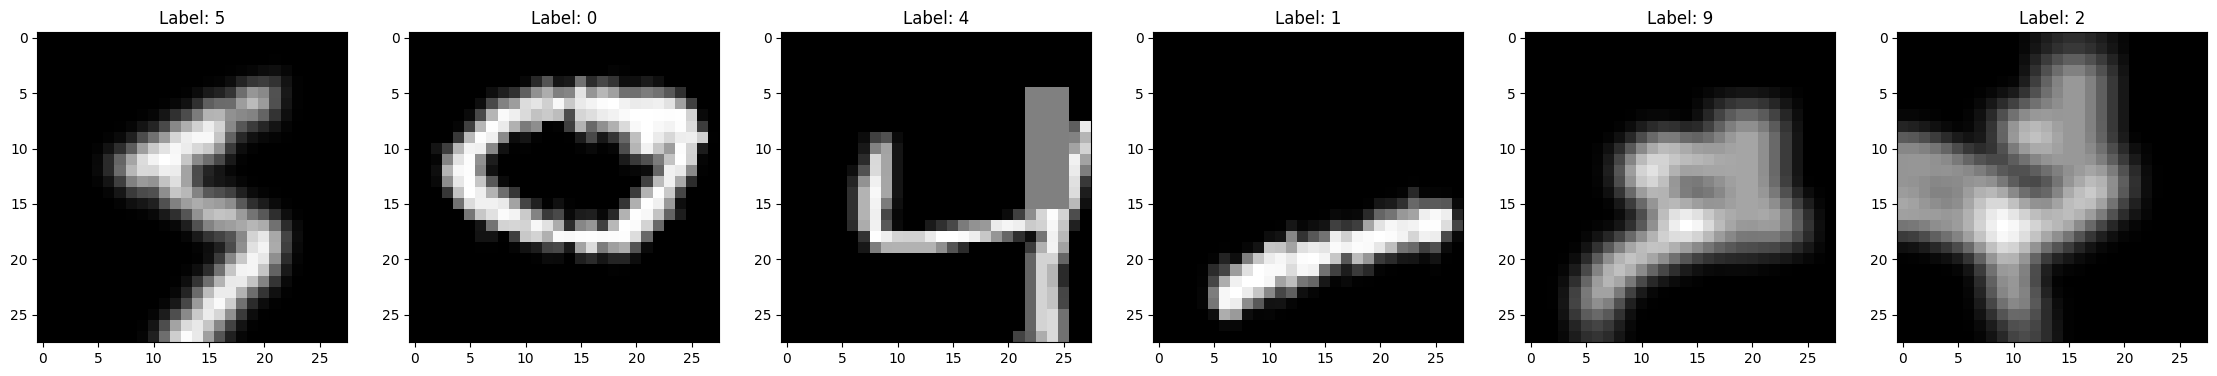

In [5]:
def show_images(images, labels):
    fig, axes = plt.subplots(1, 6, figsize=(28, 28))
    
    for i in range(6):
        axes[i].imshow(images[i].squeeze(), cmap='gray')
        axes[i].set_title(f'Label: {labels[i]}')
    plt.show()

data_iter = iter(dataloader)
images, labels = next(data_iter)

show_images(images, labels)

#### Train the Model

In [33]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten() 
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)    
        self.fc3 = nn.Linear(64, 10)  
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x


model = MLP()
criterion = nn.NLLLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 15
for epoch in range(num_epochs):
    for images, labels in dataloader:
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/15], Loss: 1.1379
Epoch [2/15], Loss: 0.7658
Epoch [3/15], Loss: 0.8602
Epoch [4/15], Loss: 0.9267
Epoch [5/15], Loss: 0.8197
Epoch [6/15], Loss: 0.8927
Epoch [7/15], Loss: 0.4773
Epoch [8/15], Loss: 0.8652
Epoch [9/15], Loss: 0.4562
Epoch [10/15], Loss: 0.5735
Epoch [11/15], Loss: 0.5342
Epoch [12/15], Loss: 0.8558
Epoch [13/15], Loss: 0.5677
Epoch [14/15], Loss: 0.3580
Epoch [15/15], Loss: 0.6603


#### Saving the Model

In [26]:
torch.save(model.state_dict(), 'model.pth')

#### Loading the Saved Model

In [5]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten() 
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)    
        self.fc3 = nn.Linear(64, 10)  
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x
    
model = MLP()

model.load_state_dict(torch.load('model.pth'))

C:\Users\KIIT\AppData\Local\Temp\ipykernel_30080\1104402647.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))


<All keys matched successfully>

#### Validation

In [6]:
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_dataloader = DataLoader(test_dataset, batch_size=60, shuffle=True)

test_images, test_labels = next(iter(test_dataloader))
with torch.no_grad():
    test_outputs = model(test_images)
    _, predicted = torch.max(test_outputs, 1)

print(f'Predicted: {predicted[:12]}')
print(f'Actual:    {test_labels[:12]}')

Predicted: tensor([8, 1, 6, 9, 6, 7, 7, 1, 5, 1, 9, 7])
Actual:    tensor([8, 1, 6, 9, 6, 7, 7, 1, 5, 1, 9, 7])


In [ ]:
with torch.no_grad():
    for test_images, test_labels in test_dataloader:
        test_outputs = model(test_images)
        test_loss = criterion(test_outputs, test_labels)
        total_test_loss += test_loss.item()
        
        _, predicted = torch.max(test_outputs, 1)
        correct_predictions += (predicted == test_labels).sum().item()
        total_samples += test_labels.size(0)

avg_test_loss = total_test_loss / len(test_dataloader)
error_rate = 1 - (correct_predictions / total_samples)

print(f"Testing Loss: {avg_test_loss:.4f}")
print(f"Error Rate: {error_rate * 100:.2f}%")